In [1]:
import torch
import numpy as np
import mediapy
from scipy.io import savemat
import argparse
from tqdm import tqdm
from aux.tracking_viz import generate_frame_image_cv
from src.new_queries import add_new_tracks

import matplotlib.pyplot as plt
from src.factorization import marques_factorization
import rerun as rr
from src.mat_compl import alternating_matrix_completion

%load_ext autoreload
%autoreload 2

# add tapnext to pythonpath
import sys
sys.path.append("/home/manuelf/tapnet")
from tapnet.tapnext.tapnext_torch import TAPNext # type: ignore
from tapnet.tapnext.tapnext_torch_utils import restore_model_from_jax_checkpoint # type: ignore

def init_tapnext(device):

  tapnext = TAPNext(image_size=(256, 256)).to(device)

  #set model to eval, not backprop
  tapnext.eval()
  for p in tapnext.parameters():
    p.requires_grad = False

  tapnext = restore_model_from_jax_checkpoint(tapnext, "/home/manuelf/tapnet/tapnet/tapnext/tapnet/checkpoints/bootstapnext_ckpt.npz")

  return tapnext

model_video_size = (256, 256)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda:1"
video = mediapy.read_video("../mast3r/images_in/inox.mp4")[::4]  # downsample 
video = ((video / 255) - 0.5) * 2 # normalize to [-1, 1]
video_resized = mediapy.resize_video(video, model_video_size).astype(np.float32)

tapnext = init_tapnext(device)

# Design the query points array in the original video size
step = 40
ys, xs = np.meshgrid(np.linspace(8, video[0].shape[0]-step, step), np.linspace(8, video[0].shape[1]-step, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

#resize the querys points to the model size
query_points_initial[0, :, 1:3] /= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]]).to(device)

#creata tensors for the video information
video_tensor_original = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video]).unsqueeze(0).to(device) # 1, time, H, W, 3
video_tensor_resized = torch.cat([torch.tensor(frame).unsqueeze(0) for frame in video_resized]).unsqueeze(0).to(device) # 1, time, H, W, 3

/home/manuelf/miniconda3/envs/trackers/lib/python3.11/site-packages/torch/_export/utils.py:415: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(


In [2]:

# INFERENCE
next_track_id = 0  # unique ID for every track
track_histories = {}  # track_id -> list of (frame_index, (x, y)) or None
active_tracks = {}  # current_idx -> track_id (used during current step)

with torch.no_grad():
  with torch.amp.autocast('cuda', dtype=torch.float32, enabled=True):
    
    tracks, tracks_logits, visible_logits, tracking_state = tapnext(video=video_tensor_resized[:, :1], query_points=query_points_initial)

    num_feats = tracks.shape[2]
    for i in range(num_feats):
        track_id = next_track_id
        next_track_id += 1
        active_tracks[i] = track_id
        track_histories[track_id] = [(0, tracks[0, 0, i, :2].cpu())]  # frame 0 position

    for k in tqdm(range(1, video_tensor_resized.shape[1])):

        tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
            video=video_tensor_resized[:, k:k + 1],
            state=tracking_state)
        
        # trakcs_step sai sempre bem 

        visible = (visible_logits_step.squeeze() > 0).cpu()
        for i, track_tensor in enumerate(tracks_step[0, 0]):
            track_id = active_tracks.get(i, None)
            if track_id is not None:
                if visible[i]:
                    track_histories[track_id].append((k, track_tensor[:2].cpu()))
                else:
                    track_histories[track_id].append((k, None))  # Not visible

        # New feature detection
        new_tracks = add_new_tracks(tracks_step, query_points_initial)
        
        #if 0:
        if new_tracks is not None and new_tracks.shape[1] > 10:
            #print(f"Adding new tracks: {new_tracks.shape[1]}")

            new_tracks[0, :, 0] = 0  # set time to 0 for tapnext reinit

            # retain visible active tracks from previous step
            retained_indices = [i for i, v in enumerate(visible) if v]
            retained_ids = [active_tracks[i] for i in retained_indices]

            retained_tracks = tracks_step[0, 0, retained_indices].unsqueeze(0)
            zero_time = torch.zeros((1, len(retained_indices), 1)).to(retained_tracks.device)
            retained_tracks = torch.cat([zero_time, retained_tracks], dim=2)

            concat_tracks = torch.cat([retained_tracks, new_tracks.to(device)], dim=1)

            tracks_step, tracks_logits_step, visible_logits_step, tracking_state = tapnext(
                video=video_tensor_resized[:, k].unsqueeze(0),
                query_points=concat_tracks)

            # update active_tracks dict
            active_tracks = {}
            for i, id in enumerate(retained_ids):
                active_tracks[i] = id  # preserve old IDs

            new_start = len(retained_ids)
            for i in range(new_tracks.shape[1]):
                track_id = next_track_id
                next_track_id += 1
                active_tracks[new_start + i] = track_id
                track_histories[track_id] = [(k, tracks_step[0, 0, new_start + i, :2].cpu())]


num_frames = video_tensor_resized.shape[1]
output = {}

for track_id, trajectory in track_histories.items():
    coords = []
    for t in range(num_frames):
        step = next((pos for (frame, pos) in trajectory if frame == t), None)
        coords.append(step if step is not None else torch.tensor([float('nan'), float('nan')]))
    output[track_id] = torch.stack(coords)  # shape: [num_frames, 2]


output_list = [trajectory.unsqueeze(0) for _, trajectory in output.items()]
output_tensor = torch.cat(output_list, dim=0).unsqueeze(0).permute(0,2,1,3)  # shape: [1 , num_frames, num_feats, 2]

output_tensor = output_tensor[:,:,:,[1,0]]
output_tensor[:, : ,:,  :] *= torch.tensor([video[0].shape[1] / model_video_size[0], video[0].shape[0] / model_video_size[1]])

100%|██████████| 51/51 [00:26<00:00,  1.94it/s]


In [3]:
generate_frame_image_cv(video_tensor_original.cpu(), output_tensor)

100%|██████████| 52/52 [00:20<00:00,  2.52it/s]


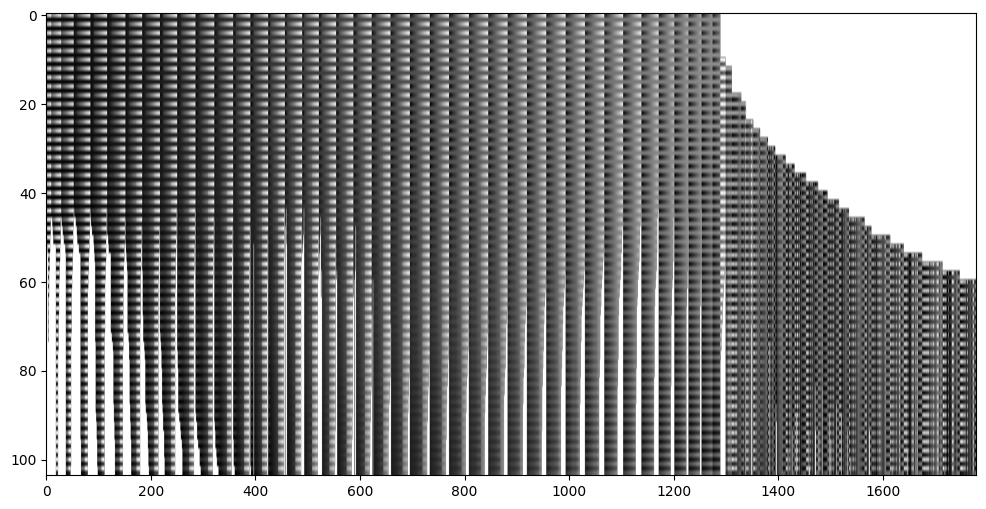

In [5]:
# Reshape the output_tensor to create the observation matrix
# Shape of output_tensor: [1, num_frames, num_feats, 2]
# Desired shape of observation_matrix: [feats*2, frames]

obs_mat_full = np.zeros((output_tensor.shape[1] * 2, output_tensor.shape[2]), dtype=np.float32)
num_frames = output_tensor.shape[1]

for frame in range(output_tensor.shape[1]): # por frame
    obs_mat_full[frame*2, :] = output_tensor[0, frame, :, 0].cpu().numpy()  # x-coordinates
    obs_mat_full[frame*2+1, :] = output_tensor[0, frame, :, 1].cpu().numpy()  # y-coordinates

#remove columns (features) that have nan values
obs_mat = obs_mat_full[:, ~np.isnan(obs_mat_full).any(axis=0)]

# remove collumns that have more than 50% nan values
obs_mat_half_missed = obs_mat_full[:, np.sum(np.isnan(obs_mat_full), axis=0) < obs_mat_full.shape[0] / 1.7]


plt.figure(figsize=(12, 6))
plt.imshow(obs_mat_half_missed, aspect='auto', cmap='gray')

 69%|██████▉   | 69/100 [00:14<00:06,  4.64it/s]


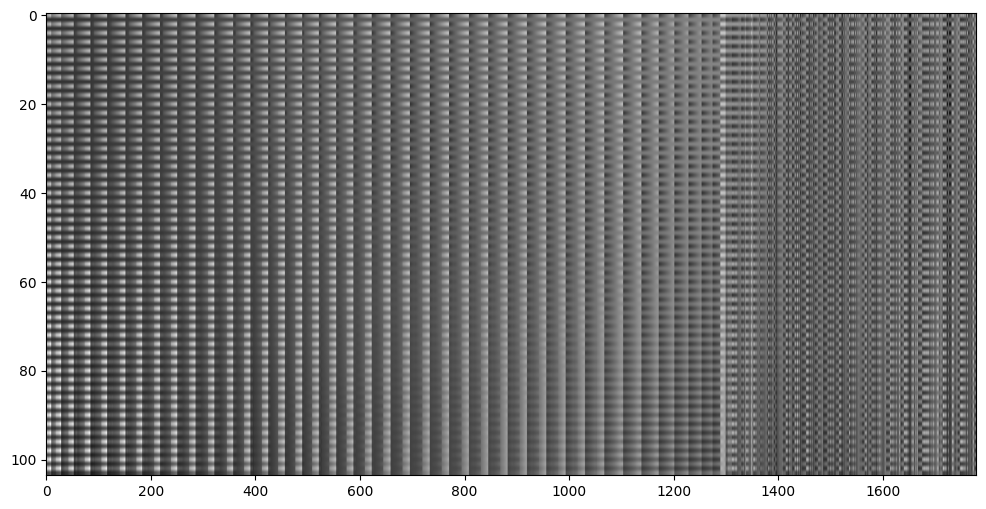

In [27]:
obs_completed, _ = alternating_matrix_completion(obs_mat_half_missed)

plt.figure(figsize=(12, 6))
plt.imshow(obs_completed, aspect='auto', cmap='gray')


In [28]:
marques_factorization(obs_completed)

(tensor([[ 0.9317,  0.2413,  0.2802],
         [ 0.9332,  0.2404,  0.2773],
         [ 0.9352,  0.2387,  0.2748],
         [ 0.9379,  0.2366,  0.2722],
         [ 0.9420,  0.2343,  0.2690],
         [ 0.9465,  0.2318,  0.2645],
         [ 0.9509,  0.2285,  0.2567],
         [ 0.9564,  0.2239,  0.2476],
         [ 0.9613,  0.2175,  0.2388],
         [ 0.9672,  0.2107,  0.2287],
         [ 0.9729,  0.2032,  0.2161],
         [ 0.9791,  0.1953,  0.2033],
         [ 0.9850,  0.1847,  0.1910],
         [ 0.9915,  0.1748,  0.1763],
         [ 0.9995,  0.1647,  0.1612],
         [ 1.0063,  0.1526,  0.1456],
         [ 1.0117,  0.1406,  0.1312],
         [ 1.0171,  0.1288,  0.1166],
         [ 1.0220,  0.1171,  0.1023],
         [ 1.0274,  0.1060,  0.0878],
         [ 1.0320,  0.0939,  0.0740],
         [ 1.0367,  0.0809,  0.0601],
         [ 1.0419,  0.0678,  0.0465],
         [ 1.0473,  0.0528,  0.0325],
         [ 1.0549,  0.0374,  0.0176],
         [ 1.0618,  0.0227,  0.0034],
         [ 1

In [30]:


rr.init("factorization")
rr.notebook_show(width=int(1920*0.75), height=int(1080*0.75))

rr.log("world/3d_shape", rr.Points3D(marques_factorization(obs_mat)[1].T))

rr.log("world/3d_completed", rr.Points3D(marques_factorization(obs_completed)[1].T))


Viewer()

In [22]:
type(obs_mat) is np.ndarray

True

In [25]:
import numpy as np
import torch
import time

# Generate random matrices
np.random.seed(42)
torch.manual_seed(42)

# Random matrix A and vector b for NumPy
A_np = np.random.rand(1000, 500)
b_np = np.random.rand(1000)

# Random matrix A and vector b for PyTorch
A_torch = torch.tensor(A_np, dtype=torch.float32)
b_torch = torch.tensor(b_np, dtype=torch.float32)

# Solve least squares using NumPy
start_time_np = time.time()
x_np, residuals_np, rank_np, s_np = np.linalg.lstsq(A_np, b_np, rcond=None)
end_time_np = time.time()

# Solve least squares using PyTorch
start_time_torch = time.time()
x_torch= torch.linalg.lstsq(A_torch, b_torch).solution
end_time_torch = time.time()

# Compare results
print("NumPy solution:")
print(x_np)
print(f"Time taken by NumPy: {end_time_np - start_time_np:.6f} seconds")

print("\nPyTorch solution:")
print(x_torch[:A_torch.shape[1]].squeeze())  # Extract the solution part
print(f"Time taken by PyTorch: {end_time_torch - start_time_torch:.6f} seconds")

NumPy solution:
[ 0.06211904  0.01607988  0.04853867 -0.04973211 -0.02684945 -0.09064287
 -0.0430919   0.03245729  0.05456711  0.04009156  0.06216896 -0.00736568
 -0.031633    0.07373349 -0.03457679 -0.08331297 -0.05624429  0.04738195
  0.01639462 -0.00843585 -0.06007183  0.01199577 -0.00796422  0.09193734
 -0.04960323  0.01331602 -0.05108109  0.05277363  0.07351458 -0.00186096
 -0.00461116  0.02018366  0.00169968  0.090563    0.01461752 -0.01559204
  0.05665519 -0.00985612  0.0473471   0.01665428  0.04703054 -0.01999431
  0.03167241  0.08013567 -0.00046768  0.01018126 -0.01569068 -0.05318752
  0.01356818  0.02636715 -0.03042592 -0.06534967  0.06441323 -0.00859092
 -0.00210835 -0.01362842 -0.07511366 -0.05322686 -0.0002307   0.05476485
  0.07255297  0.03722656  0.02251196 -0.03119043 -0.02884596 -0.01468783
 -0.03775149  0.00635437 -0.01414213 -0.02949599 -0.01113904  0.03405449
  0.04851148 -0.01622268  0.00680128  0.02364248 -0.00824613  0.08834604
  0.04346916 -0.02243308 -0.0492862